In [1]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy
import gc
from PIL import Image


root = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

sys.path.append(os.path.join(root,'imStat','code'))
import utils
import model_src
import other_model_code
from model_src import texture_statistics_pyramid
from utils import torch_utils, texture_utils, numpy_utility

import pyrtools as pt
# this is a package described at https://pyrtools.readthedocs.io/en/latest/

In [2]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


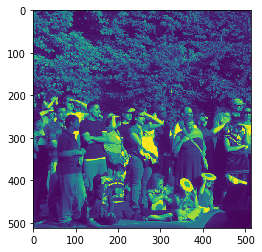

In [3]:
image = Image.open('example-im-512x512.png')
image = np.reshape(image.getdata(),[512,512])

plt.figure();
plt.pcolormesh(image)
plt.axis('square')
plt.gca().invert_yaxis()

In [4]:
# Create pyramid feature extractor (need to run cells at bottom of this notebook to create these functions)

n_ori=4;
n_sf=4;

prf_params = [0,0,0.001]

images = np.tile(np.expand_dims(np.expand_dims(image, axis=0), axis=0), [2,1,1,1])

_fmaps_fn = texture_statistics_pyramid.steerable_pyramid_extractor(pyr_height=n_sf, n_ori = n_ori)
fe = texture_statistics_pyramid.texture_feature_extractor(_fmaps_fn)
all_feat_concat, feature_info = fe(images, prf_params)



[]
Computing higher order correlations...
time elapsed: 1.97659 s
time elapsed = 10.15254
Final size of features concatenated is [2 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']

WARNING THERE ARE ZEROS IN FEATURES MATRIX

zeros for columns:
(array([4]),)


In [5]:
torch_utils.get_value(all_feat_concat)

array([[206.4318   ,   8.519109 ,  -2.8876348, ...,   7.855495 ,
         37.478306 ,   5.2913804],
       [206.4318   ,   8.519109 ,  -2.8876348, ...,   7.855495 ,
         37.478306 ,   5.2913804]], dtype=float32)

In [134]:
real_imag_across_scale_crosscorrs.shape

torch.Size([2, 96])

In [66]:
feature_types_all = ['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', \
            'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', \
            'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', \
            'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
       

In [119]:
magnitude_within_scale_crosscorrs

tensor([[-1.0959e+01, -7.0907e+00, -1.2508e+00,  1.6729e+00, -5.9232e+00,
         -1.6647e+00,  8.0606e-02, -9.0163e-02, -1.7493e-02, -2.3795e-01,
         -5.5605e-02,  2.0568e-01,  8.3019e-04,  2.1539e-03, -1.3740e-03,
          3.1315e-03, -8.3490e-04,  4.4633e-03,  8.5292e-06,  4.7410e-06,
          3.3557e-05,  6.5370e-06,  5.8477e-06,  3.3058e-06,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.0959e+01, -7.0907e+00, -1.2508e+00,  1.6729e+00, -5.9232e+00,
         -1.6647e+00,  8.0606e-02, -9.0163e-02, -1.7493e-02, -2.3795e-01,
         -5.5605e-02,  2.0568e-01,  8.3019e-04,  2.1539e-03, -1.3740e-03,
          3.1315e-03, -8.3490e-04,  4.4633e-03,  8.5292e-06,  4.7410e-06,
          3.3557e-05,  6.5370e-06,  5.8477e-06,  3.3058e-06,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
       device='cuda:0')

In [69]:
feature_dims_include = [6,16,16,10,1,\
                        272,73,25,\
                        24,24,48,96,\
                       10,20]

['magnitude_feature_autocorrs',
 'lowpass_recon_autocorrs',
 'highpass_resid_autocorrs']

In [31]:
fe = texture_feature_extractor(_fmaps_fn)
all_feat_concat, feature_info = fe(images, prf_params)

NameError: name 'texture_feature_extractor' is not defined

In [120]:
feature_info[0][473]

10

In [121]:
feature_info[1][10]

'magnitude_across_scale_crosscorrs'

In [138]:
from collections import OrderedDict

class texture_feature_extractor(nn.Module):
    
    """
    Module to compute higher-order texture statistics of input images (e.g. Portilla & Simoncelli 2000, IJCV)
    Statistics are computed within a specified region of space (a voxel's pRF)
    Can specify different subsets of features to include (i.e. pixel-level stats, simple/complex cells, cross-correlations, auto-correlations)
    Inputs to the forward pass are images and pRF parameters of interest [x,y,sigma]
    """
    
    def __init__(self,_fmaps_fn, sample_batch_size=100, feature_types_exclude=None, n_prf_sd_out=2, aperture=1.0, device=None):
        
        super(texture_feature_extractor, self).__init__()
        
        self.fmaps_fn = _fmaps_fn               
        self.n_sf = _fmaps_fn.pyr_height
        self.n_ori =  _fmaps_fn.n_ori
       
        self.sample_batch_size = sample_batch_size       
        self.n_prf_sd_out = n_prf_sd_out
        self.aperture = aperture
        self.device = device       
       
        self.update_feature_list(feature_types_exclude)
       
    def update_feature_list(self, feature_types_exclude):
        
        feature_types_all = ['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', \
            'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', \
            'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', \
            'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
        feature_type_dims = [6,16,16,10,1,\
                        272,73,25,\
                        24,24,48,96,\
                       10,20]

        if feature_types_exclude is None:
            feature_types_exclude = []
        # decide which features to ignore, or use all features
        self.feature_types_exclude = feature_types_exclude
        
        print(self.feature_types_exclude)    
        # a few shorthands for ignoring sets of features at a time
        if 'crosscorrs' in feature_types_exclude:
            feature_types_exclude.extend( [ff for ff in feature_types_all if 'crosscorrs' in ff])
        if 'autocorrs' in feature_types_exclude:
            feature_types_exclude.extend( [ff for ff in feature_types_all if 'autocorrs' in ff])
        if 'pixel' in feature_types_exclude:
            feature_types_exclude.extend(['pixel_stats'])

        self.feature_types_include  = [ff for ff in feature_types_all if not ff in feature_types_exclude]
        if len(self.feature_types_include)==0:
            raise ValueError('you have specified too many features to exclude, and now you have no features left! aborting.')
            
        feature_dims_include = [feature_type_dims[fi] for fi in range(len(feature_type_dims)) if not feature_types_all[fi] in feature_types_exclude]
        # how many features will be needed, in total?
        self.n_features_total = np.sum(feature_dims_include)
        
        # numbers that define which feature types are in which column
        self.feature_column_labels = np.squeeze(np.concatenate([fi*np.ones([1,feature_dims_include[fi]]) for fi in range(len(feature_dims_include))], axis=1).astype('int'))
        assert(np.size(self.feature_column_labels)==self.n_features_total)

    
    def forward(self, images, prf_params):
        
        if isinstance(prf_params, torch.Tensor):
            prf_params = torch_utils.get_value(prf_params)
        assert(np.size(prf_params)==3)
        prf_params = np.squeeze(prf_params)
        if isinstance(images, torch.Tensor):
            images = torch_utils.get_value(images)

        print('Computing higher order correlations...')
      
        t = time.time()
        pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
            magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
            magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
            real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs =  \
                    get_higher_order_features(self.fmaps_fn, images, prf_params, sample_batch_size=self.sample_batch_size, n_prf_sd_out=self.n_prf_sd_out, aperture=self.aperture, device=self.device)
        
        
        elapsed =  time.time() - t
        print('time elapsed = %.5f'%elapsed)

        all_feat = OrderedDict({'pixel_stats':pixel_stats, 'mean_magnitudes':mean_magnitudes, 'mean_realparts':mean_realparts, \
                                'marginal_stats_lowpass_recons':marginal_stats_lowpass_recons, 'variance_highpass_resid':variance_highpass_resid, \
            'magnitude_feature_autocorrs':magnitude_feature_autocorrs, 'lowpass_recon_autocorrs':lowpass_recon_autocorrs, 'highpass_resid_autocorrs':highpass_resid_autocorrs, \
            'magnitude_within_scale_crosscorrs':magnitude_within_scale_crosscorrs, 'real_within_scale_crosscorrs':real_within_scale_crosscorrs, \
            'magnitude_across_scale_crosscorrs':magnitude_across_scale_crosscorrs, 'real_imag_across_scale_crosscorrs':real_imag_across_scale_crosscorrs, \
            'real_spatshift_within_scale_crosscorrs':real_spatshift_within_scale_crosscorrs, 'real_spatshift_across_scale_crosscorrs':real_spatshift_across_scale_crosscorrs})

        feature_names_full = list(all_feat.keys())
        feature_names = [fname for fname in feature_names_full if fname in self.feature_types_include]
        assert(feature_names==self.feature_types_include) # double check here that the order is correct
        
        for ff, feature_name in enumerate(feature_names):   
            assert(all_feat[feature_name] is not None)
            if ff==0:
                all_feat_concat = all_feat[feature_name]
            else:               
                all_feat_concat = torch.cat((all_feat_concat, all_feat[feature_name]), axis=1)

        assert(all_feat_concat.shape[1]==self.n_features_total)
        print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
        print('Feature types included are:')
        print(feature_names)

        if torch.any(torch.isnan(all_feat_concat)):
            print('\nWARNING THERE ARE NANS IN FEATURES MATRIX\n')
        if torch.any(torch.sum(all_feat_concat, axis=0)==0):
            print('\nWARNING THERE ARE ZEROS IN FEATURES MATRIX\n')
            print('zeros for columns:')
            print(np.where(torch.sum(all_feat_concat, axis=0)==0))
        return all_feat_concat, [self.feature_column_labels, feature_names]
    

In [64]:
_fmaps_fn.

In [5]:
import torch.nn as nn

class steerable_pyramid_extractor(nn.Module):
    
    """
    Module that utilizes steerable pyramid ( https://pyrtools.readthedocs.io/en/latest/) to extract features.
    For a batch of input images, will return all the pyramid coefficients, as well as additional types of feature maps
    (i.e. partially reconstructed lowpass images at several frequency levels, upsampled feature maps).
    These are used by 'get_higher_order_features' to extract various textural features of the image.
    Adapted by MH from code in the library at:
    https://github.com/freeman-lab/metamers
    """
    
    def __init__(self, pyr_height=4, n_ori=8):
        
        super(steerable_pyramid_extractor, self).__init__()       
        self.n_ori = n_ori
        self.pyr_height = pyr_height # how many spatial frequencies?
        self.pyr = None
        
    def forward(self, image_batch, to_torch=False, device=None):
        
        batch_size = image_batch.shape[0]
        t  = time.time()
        for ii in range(batch_size):
            
            # Call the pyramid generation code here, get all features for this image.
            pyr = pt.pyramids.SteerablePyramidFreq(image_batch[ii,0,:,:], is_complex=True, height = self.pyr_height, order = self.n_ori-1)
            self.pyr = pyr # storing the most recently generated pyramid, in case we need its properties later
            
            if ii==0:  
                
                # Initialize all the feature maps we want to store...
                fmaps_complex = []
                fmaps_coarser_upsampled = []
               
                # Will generate several low-pass filtered representations of the image - will use these as additional feature maps for 
                # computing autocorrelations and marginal statistics.
                fmaps_lowpass_recon = []
                fmaps_lowpass_recon.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
               
                # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
                sf_reverse  = self.pyr_height  # need to go backward because pyr comes out in the opposite order from what i want
                for sf in range(self.pyr_height):
                    sf_reverse -= 1
                    fmaps_complex.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))
                    
                    # Initialize "parent" representations for this level (map from the next coarsest resolution, upsampled to the finer scale)
                    # To be used for cross-scale comparisons.
                    if sf==0:
                        # this will be the lowpass residual (non-oriented).
                        fmaps_coarser_upsampled.append(np.zeros((batch_size, 1,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))                     
                    else:
                        fmaps_coarser_upsampled.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))     
                        
                    fmaps_lowpass_recon.append(np.zeros((batch_size,1,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                         pyr.pyr_coeffs[sf_reverse,0].shape[1])))

                fmaps_resid = []    
                fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
                fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_highpass'].shape[0],pyr.pyr_coeffs['residual_highpass'].shape[1])))

            # First get lowpass filtered representation of the image
            lowpass_recon = pyr.recon_pyr(levels='residual_lowpass', bands='all', twidth=1) 
            scale_by = pyr.pyr_size[(0,0)][0]/pyr.pyr_size['residual_lowpass'][0]
            lowpass_recon = texture_utils.shrink(lowpass_recon, scale_by)*scale_by**2
            fmaps_lowpass_recon[0][ii,0,:,:] = lowpass_recon
            
            # Get the "parent" for lowest SF level (upsample the residual lowpass)
            upsampled = texture_utils.expand(pyr.pyr_coeffs['residual_lowpass'], factor=2)/2**2
            fmaps_coarser_upsampled[0][ii,0,:,:] = upsampled
            
            # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
            sf_reverse  = self.pyr_height # need to go backward because pyr comes out in the opposite order from what i want
            for sf in range(self.pyr_height):
                sf_reverse -= 1
                for oo in range(self.n_ori):     

                    # These are the main feature maps of the pyramid - one feature map per scale per orientation band.
                    # Complex number, can take the magnitude or real/imaginary part to simulate complex or simple cell-type responses.
                    fmaps_complex[sf][ii,oo,:,:] = pyr.pyr_coeffs[(sf_reverse,oo)]
                    
                    if sf<self.pyr_height-1:
                        # Store this as a "parent" representation, will be used for the next most fine SF level (i.e. sf+1)
                        upsampled = texture_utils.expand(pyr.pyr_coeffs[(sf_reverse,oo)], factor=2)/2**2
                        # Double the phase (angle of the complex number); note this doesn't affect the magnitude. 
                        phase_doubled = texture_utils.double_phase(upsampled)
                        fmaps_coarser_upsampled[sf+1][ii,oo,:,:] = phase_doubled
                   
                        
                # Get the bandpass filtered representation for this scale
                bandpass_image = np.real(pyr.recon_pyr(levels=sf_reverse, bands='all', twidth=1))
                scale_by = pyr.pyr_size[(0,0)][0]/pyr.pyr_size[(sf_reverse,0)][0]
                bandpass_image = texture_utils.shrink(bandpass_image, factor=scale_by)*scale_by**2
                
                # Add it onto the lowpass_recon (gets modified every loop iteration)
                lowpass_recon = texture_utils.expand(lowpass_recon, factor=2)/2**2
                lowpass_recon = lowpass_recon + bandpass_image
                fmaps_lowpass_recon[sf+1][ii,0,:,:] = lowpass_recon
            

            # Grab residual feature maps, the lowest and highest levels of the pyramid
            fmaps_resid[0][ii,0,:,:] = pyr.pyr_coeffs['residual_lowpass']
            fmaps_resid[1][ii,0,:,:] = pyr.pyr_coeffs['residual_highpass']
            
            
        elapsed = time.time() - t
        print('time elapsed: %.5f s'%elapsed)

        if to_torch:            
            fmaps_complex = [torch.from_numpy(fm).to(device) for fm in fmaps_complex]            
            fmaps_resid = [torch_utils._to_torch(fm, device=device) for fm in fmaps_resid]
            fmaps_lowpass_recon = [torch_utils._to_torch(fm, device=device) for fm in fmaps_lowpass_recon]                      
            fmaps_coarser_upsampled = [torch.from_numpy(fm).to(device) for fm in fmaps_coarser_upsampled]

        return fmaps_complex, fmaps_resid, fmaps_lowpass_recon, fmaps_coarser_upsampled
    
   
        

In [8]:
autocorr_output_pix=np.array([3,3,5,7,7])
n_autocorr_vals = ((autocorr_output_pix**2+1)/2).astype('int')

autocorr_output_pix[0]

3

In [130]:

def get_higher_order_features(_fmaps_fn, images, prf_params, sample_batch_size=20, n_prf_sd_out=2, aperture=1.0, device=None):

    """
    Compute higher order texture features for a batch of images.
    Input the module that defines steerable pyramid (i.e. 'steerable_pyramid_extractor'), and desired prf parameters.
    Returns arrays of each higher order feature.  
    Adapted by MH from code in the library at:
    https://github.com/freeman-lab/metamers
    """

    n_trials = np.shape(images)[0]
    x,y,sigma = prf_params

    n_sf = _fmaps_fn.pyr_height
    n_ori = _fmaps_fn.n_ori
        
    # all pairs of different orientation channels.
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]

    # mean, variance, skew, kurtosis, min, max
    pixel_stats = torch.zeros((n_trials,6), device=device)

    # Mean magnitude each scale/orientation, within the prf.
    mean_magnitudes = torch.zeros((n_trials, n_sf, n_ori), device=device)
    mean_realparts = torch.zeros((n_trials, n_sf, n_ori), device=device)

    # Store the skew and kurtosis of the lowpass reconstructions at each scale
    marginal_stats_lowpass_recons = torch.zeros((n_trials, n_sf+1, 2), device=device)

    # Variance of the highpass residual
    variance_highpass_resid = torch.zeros((n_trials, 1), device=device)

    # how many unique autocorrelation values will we get out for each feature map? These will be pre-defined, same for every pRF.
    # but different for different scales of feature maps.
    # note also that for bigger prfs, there will potentially be more pixels that contribute to the autocorrelation computation - 
    # but a fixed portion of the matrix is returned.
    autocorr_output_pix=np.array([3,3,5,7,7])
    n_autocorr_vals = ((autocorr_output_pix**2+1)/2).astype('int')
    max_autocorr_vals = np.max(n_autocorr_vals)
    
    # Spatial autocorrelation of the magnitude of spectral coefficients, within each scale and orientation.
    magnitude_feature_autocorrs = torch.zeros([n_trials, n_sf, n_ori, max_autocorr_vals], device=device) # this is ace in the matlab code

    # Spatial autocorrelation of the partially-reconstructed lowpass image representation at each scale
    lowpass_recon_autocorrs = torch.zeros([n_trials, n_sf+1, max_autocorr_vals], device=device) # this is acr in the matlab code

    # Spatial autocorrelation of the highpass residual
    highpass_resid_autocorrs = torch.zeros([n_trials, 1, max_autocorr_vals], device=device)

    # Within scale correlations of feature maps: compare feature map magnitudes for different orientations.
    magnitude_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori_pairs], device=device) # this is C0 in the matlab code
    # Using the real parts.
    real_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori_pairs], device=device) # this is Cr0 in the matlab code

    # Cross-scale correlations of feature maps: always comparing each scale to an up-sampled version of the scale coarser than it.
    magnitude_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, n_ori, n_ori], device=device) # this is Cx0 in the matlab code

    # Cross-scale correlations, using the real and imaginary parts separately. The phase (angle) of the coarser map is doubled before computing these.
    real_imag_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, 2, n_ori, n_ori], device=device) # this is Crx0 in the matlab code

    # These are comparisons with spatially shifted versions of the lowpass residual. Not sure we need this...
    n_spatshifts = 5;
    real_spatshift_within_scale_crosscorrs = torch.zeros([n_trials, 1, n_spatshifts, n_spatshifts], device=device)# this is Cr0 in the matlab code
    real_spatshift_across_scale_crosscorrs = torch.zeros([n_trials, 1, n_ori, n_spatshifts], device=device)  # this is Crx0 in the matlab code

    # Looping over batches of trials to compute everything of interest.
    bb=-1
    for batch_inds, batch_size_actual in numpy_utility.iterate_range(0, n_trials, sample_batch_size):
        bb=bb+1

        fmaps_complex, fmaps_resid, fmaps_lowpass_recon, fmaps_coarser_upsampled = _fmaps_fn(images[batch_inds], to_torch=True, device=device)

        if bb==0:
            npix_each_scale = [_fmaps_fn.pyr.pyr_size[(sc,0)][0] for sc in range(n_sf)]
            npix_each_scale.append(_fmaps_fn.pyr.pyr_size['residual_lowpass'][0])
            npix_each_scale.reverse()
            
        # First working with the finest scale (original image)
        n_pix = npix_each_scale[-1]      
        g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        spatial_weights = g[2][0]
        patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[-1])

        # Gather pixel-wise statistics here 
        wmean, wvar, wskew, wkurt = texture_utils.get_weighted_pixel_features(images[batch_inds], spatial_weights, device=device)
        pixel_stats[batch_inds,0] = torch.squeeze(wmean)
        pixel_stats[batch_inds,1] = torch.squeeze(wvar)
        pixel_stats[batch_inds,2] = torch.squeeze(wskew)
        pixel_stats[batch_inds,3] = torch.squeeze(wkurt)
        pixel_stats[batch_inds,4] = torch_utils._to_torch(np.squeeze(np.min(np.min(images[batch_inds], axis=3), axis=2)), device=device)
        pixel_stats[batch_inds,5] = torch_utils._to_torch(np.squeeze(np.max(np.max(images[batch_inds], axis=3), axis=2)), device=device)

        # Autocorrs of the highpass residual
        highpass_resid = fmaps_resid[1]
        auto_corr = texture_utils.weighted_auto_corr_2d(highpass_resid, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[-1], subtract_patch_mean = True, enforce_size=True, device=device)       
        highpass_resid_autocorrs[batch_inds,0,0:n_autocorr_vals[-1]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[-1]])

        # Variance of the highpass residual
        m, wvar, s, k = texture_utils.get_weighted_pixel_features(highpass_resid, spatial_weights, device=device)
        variance_highpass_resid[batch_inds,0] = torch.squeeze(wvar)

        # Next work with the low-pass reconstruction (most coarse scale, smallest npix)
        n_pix = npix_each_scale[0]       
        g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        spatial_weights = g[2][0]
        patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[0])

        lowpass_rec = fmaps_lowpass_recon[0]

        # Marginal stats of low-pass reconstruction
        m, v, wskew, wkurt = texture_utils.get_weighted_pixel_features(lowpass_rec, spatial_weights, device=device)
        marginal_stats_lowpass_recons[batch_inds,0,0] = torch.squeeze(wskew)
        marginal_stats_lowpass_recons[batch_inds,0,1] = torch.squeeze(wkurt)

        # Autocorrs of low-pass reconstruction 
        auto_corr = texture_utils.weighted_auto_corr_2d(lowpass_rec, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[0], subtract_patch_mean = True, enforce_size=True, device=device)       
        lowpass_recon_autocorrs[batch_inds,0,0:n_autocorr_vals[0]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[0]])

        # Looping over spatial frequency/scale
        # Loop goes low SF (smallest npix) to higher SF (largest npix)
        for ff in range(n_sf):
         
            # Scale specific things - get the prf at this resolution of interest    
            n_pix = npix_each_scale[ff+1]           
            g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
            spatial_weights = g[2][0]
            patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[1+ff])

            # Get the low-pass reconstruction at this scale
            lowpass_summed = fmaps_lowpass_recon[ff+1]  # this is summed over this scale band and those below it
            m, v, wskew, wkurt = texture_utils.get_weighted_pixel_features(lowpass_summed, spatial_weights, device=device)
            marginal_stats_lowpass_recons[batch_inds,ff+1,0] = torch.squeeze(wskew)
            marginal_stats_lowpass_recons[batch_inds,ff+1,1] = torch.squeeze(wkurt)

            # Autocorrelations of low-pass reconstruction (at this scale)
            auto_corr = texture_utils.weighted_auto_corr_2d(lowpass_summed, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[ff+1], subtract_patch_mean = True, enforce_size=True, device=device)       
            lowpass_recon_autocorrs[batch_inds,ff+1,0:n_autocorr_vals[1+ff]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[1+ff]])

            # Loop over orientation channels
            xx=-1
            for oo1 in range(n_ori):       

                # Magnitude of the complex coefficients; complex cell-like responses
                mag1 = torch.abs(fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                # The mean magnitudes here are basically second-order spectral statistics, within the specified spatial region defined by weights
                wmean, v, s, k = texture_utils.get_weighted_pixel_features(mag1, spatial_weights/np.sum(spatial_weights), device=device)
                mean_magnitudes[batch_inds, ff, oo1] = torch.squeeze(wmean)
                
                mag1 = mag1 - torch.tile(torch.mean(torch.mean(mag1, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                # Real parts of the complex coefficients; simple cell-like responses
                real1 = torch.real(fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()    
                
                # Average of the real parts within the specified spatial region
                wmean, v, s, k = texture_utils.get_weighted_pixel_features(real1, spatial_weights/np.sum(spatial_weights), device=device)
                mean_realparts[batch_inds, ff, oo1] = torch.squeeze(wmean)

                # Complex cell autocorrelation (correlation w spatially shifted versions of itself)     
                auto_corr = texture_utils.weighted_auto_corr_2d(mag1, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[ff+1], subtract_patch_mean = True, enforce_size=True, device=device)       
                magnitude_feature_autocorrs[batch_inds,ff,oo1,0:n_autocorr_vals[1+ff]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[1+ff]])

                # Within-scale correlations - comparing resp at orient==oo1 to responses at all other orientations, same scale.
                for oo2 in np.arange(oo1+1, n_ori):            
                    xx = xx+1 
                    assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                    # Magnitude at the other orientation (oo2)
                    mag2 = torch.abs(fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()      
                    mag2 = mag2 - torch.tile(torch.mean(torch.mean(mag2, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                    # Correlate the magnitude feature maps for the two orientations, within scale
                    cross_corr = texture_utils.weighted_cross_corr_2d(mag1, mag2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)
                    magnitude_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                    # Real part at the other orientation (oo2)
                    real2 = torch.real(fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()                     

                    # Correlate the real feature maps for the two orientations, within scale
                    cross_corr = texture_utils.weighted_cross_corr_2d(real1, real2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)
                    real_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                # Cross-scale correlations - for these we care about same ori to same ori, so looping over all orientations.
                # Going to compare coefficients at the current scale to those at a coarser scale (ff-1)
                # If we're at first scale (ff=0), then will use a different method.
                if ff>0:

                    for oo2 in range(n_ori):

                        # Get magnitude of coefficients for neighboring (coarser) scale                        
                        mag_coarser2 = torch.abs(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()
                        mag_coarser2 = mag_coarser2 - torch.tile(torch.mean(torch.mean(mag_coarser2, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                        # Correlate this with the finer scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(mag1, mag_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)            
                        magnitude_across_scale_crosscorrs[batch_inds,ff-1,oo1,oo2] = torch.squeeze(cross_corr)

                        # Get the real and imaginary parts at coarser scale
                        real_coarser2 = torch.real(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()
                        imag_coarser2 = torch.imag(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                        # Correlate each of these with real part at finer scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, real_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_imag_across_scale_crosscorrs[batch_inds,ff-1,0,oo1,oo2] = torch.squeeze(cross_corr)

                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, imag_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_imag_across_scale_crosscorrs[batch_inds,ff-1,1,oo1,oo2] = torch.squeeze(cross_corr)

                else:

                    # instead of different orientations for the "parent" level here, have spatially shifted versions.
                    real_coarser = torch.real(fmaps_coarser_upsampled[ff][:,0,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                    shifts = [[0,0],[1,3],[-1,3],[1,2],[-1,2]]
                    for si1, shift1 in enumerate(shifts):

                        ss,dd = shift1
                        real_coarser_shifted1 = torch.roll(real_coarser, shifts=ss, dims=dd)               
                        # Real part at the finer scale compared to spatially shifted at the coarser scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, real_coarser_shifted1, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_spatshift_across_scale_crosscorrs[batch_inds,ff,oo1,si1] = torch.squeeze(cross_corr)

                        for si2 in np.arange(si1+1, n_spatshifts):

                            ss,dd = shifts[si2]
                            real_coarser_shifted2 = torch.roll(real_coarser, shifts=ss, dims=dd) 
                            # Real parts at same scale, comparing spatially shifted.
                            cross_corr = texture_utils.weighted_cross_corr_2d(real_coarser_shifted1, real_coarser_shifted2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                            real_spatshift_within_scale_crosscorrs[batch_inds,ff,si1,si2] = torch.squeeze(cross_corr)

            
    # Reshape everything to [ntrials x nfeatures]
    
    mean_magnitudes = torch.reshape(mean_magnitudes, [n_trials, -1])
    mean_realparts = torch.reshape(mean_realparts, [n_trials, -1])
    marginal_stats_lowpass_recons = torch.reshape(marginal_stats_lowpass_recons, [n_trials, -1])
    variance_highpass_resid =torch.reshape(variance_highpass_resid, [n_trials, -1])

    magnitude_feature_autocorrs = torch.reshape(magnitude_feature_autocorrs, [n_trials, -1])
    # take out the zero columns, which happen because of different size autocorr outputs.
    magnitude_feature_autocorrs = magnitude_feature_autocorrs[:,torch.sum(magnitude_feature_autocorrs, axis=0)!=0]
    assert(magnitude_feature_autocorrs.shape[1]==np.sum(n_autocorr_vals[1:]*n_ori))

    lowpass_recon_autocorrs = torch.reshape(lowpass_recon_autocorrs, [n_trials, -1])
    lowpass_recon_autocorrs = lowpass_recon_autocorrs[:,torch.sum(lowpass_recon_autocorrs, axis=0)!=0]
    assert(lowpass_recon_autocorrs.shape[1]==np.sum(n_autocorr_vals))

    highpass_resid_autocorrs = torch.reshape(highpass_resid_autocorrs, [n_trials, -1])

    magnitude_within_scale_crosscorrs = torch.reshape(magnitude_within_scale_crosscorrs, [n_trials, -1])
    real_within_scale_crosscorrs = torch.reshape(real_within_scale_crosscorrs, [n_trials, -1])
    magnitude_across_scale_crosscorrs = torch.reshape(magnitude_across_scale_crosscorrs, [n_trials, -1])
    real_imag_across_scale_crosscorrs = torch.reshape(real_imag_across_scale_crosscorrs, [n_trials, -1])
    real_spatshift_within_scale_crosscorrs = torch.reshape(real_spatshift_within_scale_crosscorrs, [n_trials, -1])
    
    real_spatshift_within_scale_crosscorrs = real_spatshift_within_scale_crosscorrs[:,torch.sum(real_spatshift_within_scale_crosscorrs, axis=0)!=0]
    assert(real_spatshift_within_scale_crosscorrs.shape[1]==np.sum(np.arange(1,n_spatshifts)))

    real_spatshift_across_scale_crosscorrs = torch.reshape(real_spatshift_across_scale_crosscorrs, [n_trials, -1])

        
    return pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
            magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
            magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
            real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs


    

In [9]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse

# import custom modules
root_dir   = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root_dir,'code'))
from model_src import fwrf_fit as fwrf_fit
from model_src import fwrf_predict as fwrf_predict
from model_src import texture_statistics_gabor, texture_statistics_pyramid

from model_fitting import initialize_fitting

fpX = np.float32

In [12]:
subject=1
roi=None

ridge=0

shuffle_images=0
random_images=0
random_voxel_data=0

sample_batch_size=100
voxel_batch_size=100
zscore_features=1
nonlin_fn=0
padding_mode='circular'

n_ori=8
n_sf=4
up_to_sess=1
debug=1
shuff_rnd_seed=0
# shuff_rnd_seed=251709

fitting_type='texture'



do_fitting=1
do_val=1
do_partial=1
date_str=None

In [13]:
device = initialize_fitting.init_cuda()
nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
model_name, feature_types_exclude = initialize_fitting.get_pyramid_model_name(ridge, n_ori, n_sf)

if do_fitting==False and date_str is None:
    raise ValueError('if you want to start midway through the process (--do_fitting=False), then specify the date when training result was saved (--date_str).')

if do_fitting==True and date_str is not None:
    raise ValueError('if you want to do fitting from scratch (--do_fitting=True), specify --date_str=None (rather than entering a date)')

output_dir, fn2save = initialize_fitting.get_save_path(root_dir, subject, model_name, shuffle_images, random_images, random_voxel_data, debug, date_str)

def save_all():
    print('\nSaving to %s\n'%fn2save)
    torch.save({
    'aperture': aperture,
    'aperture_rf_range': aperture_rf_range,
    'models': models,
    'include_autocorrs': include_autocorrs,
    'feature_info':feature_info,
    'voxel_mask': voxel_mask,
    'brain_nii_shape': brain_nii_shape,
    'image_order': image_order,
    'voxel_index': voxel_index,
    'voxel_roi': voxel_roi,
    'voxel_ncsnr': voxel_ncsnr, 
    'best_params': best_params,
    'lambdas': lambdas, 
    'best_lambdas': best_lambdas,
    'best_losses': best_losses,
    'val_cc': val_cc,
    'val_r2': val_r2,   
    'val_cc_partial': val_cc_partial,
    'val_r2_partial': val_r2_partial,   
    'features_each_model_val': features_each_model_val,
    'voxel_feature_correlations_val': voxel_feature_correlations_val,
    'zscore_features': zscore_features,
    'nonlin_fn': nonlin_fn,
    'n_prf_sd_out': n_prf_sd_out,
    'debug': debug,
    'up_to_sess': up_to_sess,
    'shuff_rnd_seed': shuff_rnd_seed
    }, fn2save, pickle_protocol=4)


# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = initialize_fitting.get_voxel_info(mask_root, beta_root, subject, roi)

# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_single_trial_data, val_voxel_single_trial_data, \
    n_voxels, n_trials_val, image_order = initialize_fitting.get_data_splits(nsd_root, beta_root, stim_root, subject, voxel_mask, up_to_sess, 
                                                                             shuffle_images=shuffle_images, random_images=random_images, random_voxel_data=random_voxel_data)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32
Time Stamp: Jul-21-2021_0456

Will save final output file to /user_data/mmhender/model_fits/S01/texture_pyramid_OLS_8ori_4sf/Jul-21-2021_0456_DEBUG/

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

In [14]:
trn_stim_data.shape

(688, 1, 227, 227)

In [21]:
30*8

240

In [28]:
import skimage

process_at_size=240
trn_stim_data = skimage.transform.resize(trn_stim_data, output_shape=(trn_stim_data.shape[0],1,process_at_size, process_at_size))
val_stim_single_trial_data = skimage.transform.resize(val_stim_single_trial_data, output_shape=(val_stim_single_trial_data.shape[0],1,process_at_size, process_at_size))

In [29]:
240/2/2/2

30.0

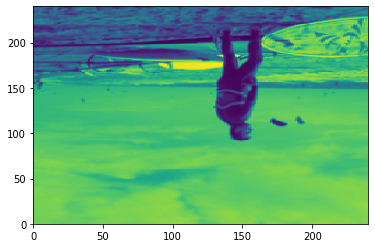

In [27]:
plt.figure;
plt.pcolormesh(resized[0,0,:,:])